# Bollinger band - Mean reverting strategy. CBOM.ME

In [1]:
import pandas as pd
import pandas_datareader as dr
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
from numpy.linalg import inv
from statsmodels.api import OLS
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr
# To perform ADF Test
from statsmodels.tsa.stattools import adfuller

In [2]:
data_CBOM = dr.get_data_yahoo("CBOM.ME")
data_CBOM.sort_values(by=['Date'], inplace=True)
data_CBOM.rename(columns={"Adj Close":"Price"}, inplace=True)
# Период, за который рассматривается скользящее значение
lookback=5
# Скользящее среднее
data_CBOM['moving_average'] = data_CBOM['Price'].rolling(lookback).mean()

# Скользящее стандартное отклонение
data_CBOM['moving_std_dev'] = data_CBOM['Price'].rolling(lookback).std()
data_CBOM.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

data_CBOM['upper_band'] = data_CBOM.moving_average + 0.5*data_CBOM.moving_std_dev
data_CBOM['lower_band'] = data_CBOM.moving_average - 0.5*data_CBOM.moving_std_dev

data_CBOM['long_entry'] = data_CBOM.Price < data_CBOM.lower_band   
data_CBOM['long_exit'] = data_CBOM.Price >= data_CBOM.moving_average

data_CBOM['short_entry'] = data_CBOM.Price > data_CBOM.upper_band   
data_CBOM['short_exit'] = data_CBOM.Price <= data_CBOM.moving_average

data_CBOM['positions_long'] = np.nan  
data_CBOM.loc[data_CBOM.long_entry,'positions_long']= 1  
data_CBOM.loc[data_CBOM.long_exit,'positions_long']= 0  
  
data_CBOM['positions_short'] = np.nan  
data_CBOM.loc[data_CBOM.short_entry,'positions_short']= -1  
data_CBOM.loc[data_CBOM.short_exit,'positions_short']= 0  
data_CBOM = data_CBOM.fillna(method='ffill')  

data_CBOM['positions'] = data_CBOM.positions_long + data_CBOM.positions_short
data_CBOM['prices_difference']= data_CBOM.Price - data_CBOM.Price.shift(1)
data_CBOM['daily_returns'] = data_CBOM.prices_difference /data_CBOM.Price.shift(1)
data_CBOM['pnl'] = data_CBOM.positions.shift(1) * data_CBOM.daily_returns
data_CBOM['cumpnl'] = (data_CBOM.pnl+1).cumprod() - 1

In [3]:
data_CBOM

,Price,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,short_entry,short_exit,positions_long,positions_short,positions,prices_difference,daily_returns,pnl,cumpnl
Date,,,,,,,,,,,,,,,,
2015-07-01,3.579847,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,3.546287,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-0.033561,-0.009375,NaN,NaN
2015-07-03,3.538022,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,-0.008265,-0.002331,NaN,NaN
2015-07-06,3.570120,NaN,NaN,NaN,NaN,False,False,False,False,NaN,NaN,NaN,0.032098,0.009072,NaN,NaN
2015-07-07,3.532182,3.553291,0.020714,3.563648,3.542934,True,False,False,True,1.0,0.0,1.0,-0.037938,-0.010627,NaN,NaN
2015-07-08,3.549693,3.547261,0.014510,3.554516,3.540006,False,True,False,False,0.0,0.0,0.0,0.017512,0.004958,0.004958,0.004958
2015-07-09,3.550665,3.548136,0.014568,3.555420,3.540852,False,True,False,False,0.0,0.0,0.0,0.000972,0.000274,0.000000,0.004958
2015-07-10,3.550665,3.550665,0.013426,3.557378,3.543952,False,False,False,True,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.004958
2015-07-13,3.555043,3.547649,0.008892,3.552095,3.543203,False,True,True,False,0.0,-1.0,-1.0,0.004378,0.001233,0.000000,0.004958


# Moving Average Convergence Divergence (MACD) strategy
# one of the simplest and effective trend-following momentum indicators

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
from numpy.linalg import inv
from statsmodels.api import OLS
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr
# To perform ADF Test
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import add_constant

In [5]:
def genhurst(z):
# =============================================================================
# calculation of Hurst exponent given log price series z
# =============================================================================
    z=pd.DataFrame(z)
    
    taus=np.arange(np.round(len(z)/10)).astype(int) # We cannot use tau that is of same magnitude of time series length 
    logVar=np.empty(len(taus)) # log variance

    for tau in taus:
        logVar[tau]=np.log(z.diff(tau).var(ddof=0))
        
    X=np.log(taus)    
    Y=logVar[:len(taus)]
    X=X[np.isfinite(logVar)]
    Y=Y[np.isfinite(logVar)]
#    pd.DataFrame(np.asmatrix([X, Y]).T).to_csv('XY.csv')

    X = add_constant(X)
#    plt.scatter(X[:,1], Y) # for debug only
    model=sm.OLS(Y, X)
    results=model.fit()
    H=results.params[1]/2
    pVal=results.pvalues[1]
    return H, pVal

In [6]:
genhurst(data['Close'])

NameError: name 'data' is not defined

In [ ]:
z = data['Close']
prevz=z.shift()
dz=z-prevz
dz=dz[1:,]
prevz=prevz[1:,]
model2=OLS(dz, prevz-np.mean(prevz))
results2=model2.fit()
theta=results2.params
halflife=-np.log(2)/theta
halflife

In [ ]:
https://blog.quantinsti.com/python-trading/#Evaluation%20the%20sample%C2%A0trading%20strategy

### getting and visualizing the data

In [ ]:
# Import pandas
import pandas as pd
import pandas_datareader as dr
# Import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Read the data
data = dr.get_data_yahoo('CBOM.ME')
data.index = pd.to_datetime(data.index, dayfirst=True)

# Visualise the data
plt.figure(figsize=(10,5))
data['Close'].plot(figsize=(10,5))
plt.legend()
plt.show()

In [ ]:
# Calculate exponential moving average
data['12d_EMA'] = data.Close.ewm(span=12).mean()
data['26d_EMA'] = data.Close.ewm(span=26).mean()

data[['Close','12d_EMA','26d_EMA']].plot(figsize=(10,5))
plt.show()

In [ ]:
# Calculate MACD
data['MACD'] = data['26d_EMA'] - data['12d_EMA']

# Calculate Signal
data['Signal'] = data.MACD.ewm(span=9).mean()

data[['MACD','Signal']].plot(figsize=(10,5))
plt.show()

In [ ]:
# Import numpy
import numpy as np

# Define Signal
data['trading_signal'] = np.where(data['MACD'] > data['Signal'], 1, -1)

In [ ]:
# Calculate Returns
data['returns'] = data.Close.pct_change()

# Calculate Strategy Returns
data['strategy_returns'] = data.returns * data.trading_signal.shift(1)

# Calculate Cumulative Returns
cumulative_returns = (data.strategy_returns + 1).cumprod()-1

# Plot Strategy Returns
cumulative_returns.plot(figsize=(10,5))
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
# Calculate the cumulative strategy returns and plot
cumulative_returns.plot()
# Calculate the cumulative buy and hold strategy returns
((data.returns+1).cumprod()-1).plot()
# Set the title, label and grid
plt.title(stock_name + ' Returns')
plt.ylabel('Cumulative Returns')
plt.legend(labels=['Strategy MACD (Momentum) Returns', 'Buy and Hold Returns'])
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
# Calculate the cumulative strategy returns and plot
cumulative_returns.plot()
# Calculate the cumulative buy and hold strategy returns
((data.returns+1).cumprod()-1).plot()
#BB strategy
data_CBOM['cumpnl'].plot()
# Set the title, label and grid
plt.title(stock_name + ' Returns')
plt.ylabel('Cumulative Returns')
plt.legend(labels=['Strategy MACD (Momentum) Returns', 'Buy and Hold Returns', 'Bollinger Bands Strategy (Mean Reversion) Returns'])
plt.grid()
plt.show()

In [ ]:
### Annualised Return or Compound Annual Growth Rate (CAGR)
# Total number of trading days in a year is 252
trading_days = 252

# Calculate CAGR by multiplying the average daily returns with number of trading days
annual_returns = ((1 + data.returns.mean())**(trading_days) - 1)*100

print('The CAGR is %.2f%%' % annual_returns)

### Annualised Volatility
# Calculate the annualised volatility
annual_volatility = data.returns.std() * np.sqrt(trading_days) * 100
print('The annualised volatility is %.2f%%' % annual_volatility)

### Sharpe ratio
# Assume the annual risk-free rate is 6%
risk_free_rate = 0.06
daily_risk_free_return = risk_free_rate/trading_days

# Calculate the excess returns by subtracting the daily returns by daily risk-free return
excess_daily_returns = data.returns - daily_risk_free_return

# Calculate the sharpe ratio using the given formula
sharpe_ratio = (excess_daily_returns.mean() /
                excess_daily_returns.std()) * np.sqrt(trading_days)
print('The Sharpe ratio is %.2f' % sharpe_ratio)

In [ ]:
portfolio_MACD = pd.DataFrame(data['strategy_returns'])

In [ ]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio_MACD.mean(axis=1))

# XGBoost block

In [ ]:
#!pip install xgboost

In [7]:
from tqdm import tqdm_notebook
# Import warnings and add a filter to ignore them
import warnings
warnings.simplefilter('ignore')
# Import XGBoost
import xgboost
# XGBoost Classifier
from xgboost import XGBClassifier
# Classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Pandas datareader to get the data
from pandas_datareader import data
# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sn
# For data manipulation
import pandas as pd
import numpy as np

In [42]:
#Define parameters
# Set the stock list
stock_list = ['CBOM.ME','ALRS.ME','YNDX']#, 'LKOH.ME', 'MGNT.ME', 'GMKN.ME', 'CHMF.ME']
# Set the start date and the end date
start_date = '2004-1-1'
end_date = '2020-4-17'

We define a list of predictors from which the model will pick the best predictors. Here, we have the percentage change and the standard deviation with different time periods as the predictor variables. 

The target variable is the next day's return. If the next day’s return is positive we label it as 1 and if it is negative then we label it as -1. You can also try to create the target variables with three labels such as 1, 0 and -1 for long, no position and short.

# Feature engineering

In [43]:
# Create a placeholder to store the stock data
N = 4
stock_data_dictionary = {}
for stock_name in stock_list:
    # Get the data
    df = data.get_data_yahoo(stock_name, start_date, end_date)
    df.loc[:, 'Date'] = pd.to_datetime(df.index,format='%Y-%m-%d')
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()
    # create the predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        predictor_list.append('std_'+str(r))
    # Get difference between high and low of each day
    df['range_hl'] = df['High'] - df['Low']
    df.drop(['High', 'Low'], axis=1, inplace=True)
    # Get difference between open and close of each day
    df['range_oc'] = df['Open'] - df['Close']
    df.drop(['Open', 'Close'], axis=1, inplace=True)  
    # Add a column 'order_day' to indicate the order of the rows by date
    df['order_day'] = [x for x in list(range(len(df)))]
    # merging_keys
    merging_keys = ['order_day']
    # List of columns that we will use to create lags
    lag_cols = ['Adj Close', 'range_hl', 'range_oc', 'Volume']
    shift_range = [x+1 for x in range(N)]
    for shift in tqdm_notebook(shift_range):
        train_shift = df[merging_keys + lag_cols].copy()

        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)

    del train_shift
    # Remove the first N rows which contain NaNs
    df = df[N:]
    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)
    df = df.dropna()
    df.set_index('Date',inplace = True)
    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df})

Before we move on to the implementation of the XGBoost python model, let’s first plot the daily returns of Apple stored in the dictionary to see if everything is working fine.

In [44]:
my_list = ['range_hl', 'range_oc', 'order_day', 'Adj Close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1', 
           'Volume_lag_1', 'Adj Close_lag_2', 'range_hl_lag_2',
           'range_oc_lag_2', 'Volume_lag_2', 'Adj Close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3', 
           'Volume_lag_3', 'Adj Close_lag_4', 'range_hl_lag_4', 'range_oc_lag_4', 'Volume_lag_4']

In [45]:
for x in my_list:
    predictor_list.append(x)

In [46]:
predictor_list

['pct_change_10',
 'std_10',
 'pct_change_15',
 'std_15',
 'pct_change_20',
 'std_20',
 'pct_change_25',
 'std_25',
 'pct_change_30',
 'std_30',
 'pct_change_35',
 'std_35',
 'pct_change_40',
 'std_40',
 'pct_change_45',
 'std_45',
 'pct_change_50',
 'std_50',
 'pct_change_55',
 'std_55',
 'range_hl',
 'range_oc',
 'order_day',
 'Adj Close_lag_1',
 'range_hl_lag_1',
 'range_oc_lag_1',
 'Volume_lag_1',
 'Adj Close_lag_2',
 'range_hl_lag_2',
 'range_oc_lag_2',
 'Volume_lag_2',
 'Adj Close_lag_3',
 'range_hl_lag_3',
 'range_oc_lag_3',
 'Volume_lag_3',
 'Adj Close_lag_4',
 'range_hl_lag_4',
 'range_oc_lag_4',
 'Volume_lag_4']

In [47]:
stock_data_dictionary['CBOM.ME'].columns

Index(['Volume', 'Adj Close', 'daily_pct_change', 'pct_change_10', 'std_10',
       'pct_change_15', 'std_15', 'pct_change_20', 'std_20', 'pct_change_25',
       'std_25', 'pct_change_30', 'std_30', 'pct_change_35', 'std_35',
       'pct_change_40', 'std_40', 'pct_change_45', 'std_45', 'pct_change_50',
       'std_50', 'pct_change_55', 'std_55', 'range_hl', 'range_oc',
       'order_day', 'Adj Close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'Volume_lag_1', 'Adj Close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'Volume_lag_2', 'Adj Close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'Volume_lag_3', 'Adj Close_lag_4', 'range_hl_lag_4', 'range_oc_lag_4',
       'Volume_lag_4', 'return_next_day', 'actual_signal'],
      dtype='object')

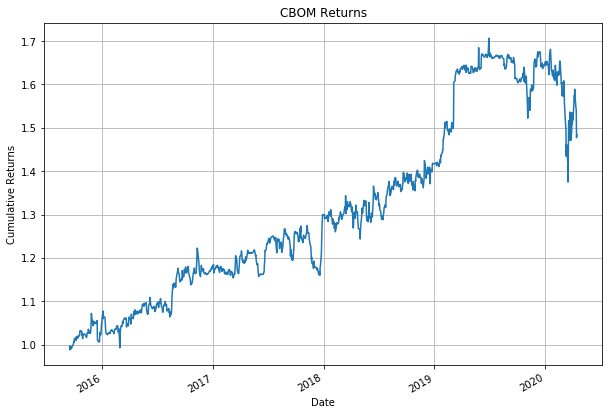

In [48]:
# Set the figure size
plt.figure(figsize=(10, 7))
# Access the dataframe of AAPL from the dictionary 
# and then compute and plot the returns
(stock_data_dictionary['CBOM.ME'].daily_pct_change+1).cumprod().plot()
# Set the title and axis labels and plot grid
plt.title('CBOM Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

Split the data into train and test.
Since XGBoost is after all a machine learning model, we will split the data set into test and train set.

In [49]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
for stock_name in stock_list:
    # Get predictor variables
    X = stock_data_dictionary[stock_name][predictor_list]
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal
    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

In [50]:
stock_data_dictionary[stock_name]

,Volume,Adj Close,daily_pct_change,pct_change_10,std_10,pct_change_15,std_15,pct_change_20,std_20,pct_change_25,...,Adj Close_lag_3,range_hl_lag_3,range_oc_lag_3,Volume_lag_3,Adj Close_lag_4,range_hl_lag_4,range_oc_lag_4,Volume_lag_4,return_next_day,actual_signal
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-11,1830100,30.660000,0.031282,-0.185243,0.066966,-0.106451,0.057262,-0.083589,0.050291,-0.079747,...,27.040001,3.709999,1.839998,2973800.0,30.830000,2.400002,1.890001,2193300.0,0.000000,-1
2011-08-12,986500,30.660000,0.000000,-0.112111,0.064279,-0.127064,0.056795,-0.107587,0.049867,-0.132456,...,29.760000,3.719999,-2.440001,1818700.0,27.040001,3.709999,1.839998,2973800.0,-0.002283,-1
2011-08-15,735300,30.590000,-0.002283,-0.051787,0.061698,-0.154873,0.056055,-0.136163,0.049318,-0.084113,...,29.730000,2.889999,-0.090000,1138400.0,29.760000,3.719999,-2.440001,1818700.0,-0.046093,-1
2011-08-16,1491800,29.180000,-0.046093,-0.088121,0.063053,-0.225310,0.055894,-0.177801,0.050087,-0.112920,...,30.660000,2.519999,-0.809999,1830100.0,29.730000,2.889999,-0.090000,1138400.0,0.028444,1
2011-08-17,1200600,30.010000,0.028444,-0.114189,0.060637,-0.225170,0.055901,-0.128099,0.050670,-0.112800,...,30.660000,1.660002,0.440001,986500.0,30.660000,2.519999,-0.809999,1830100.0,-0.014995,-1
2011-08-18,1151900,29.559999,-0.014995,-0.081579,0.059337,-0.220171,0.055884,-0.141379,0.050693,-0.118517,...,30.590000,1.490000,0.090000,735300.0,30.660000,1.660002,0.440001,986500.0,0.014547,1
2011-08-19,658700,29.990000,0.014547,-0.012448,0.057320,-0.132492,0.053883,-0.147445,0.050536,-0.127968,...,29.180000,1.880001,1.330000,1491800.0,30.590000,1.490000,0.090000,735300.0,-0.031344,-1
2011-08-22,696800,29.049999,-0.031344,0.079141,0.040592,-0.101228,0.052234,-0.204315,0.050187,-0.185605,...,30.010000,0.869999,0.139999,1200600.0,29.180000,1.880001,1.330000,1491800.0,-0.004131,-1
2011-08-23,1049800,28.930000,-0.004131,-0.025582,0.024242,-0.095600,0.052231,-0.232789,0.049554,-0.185280,...,29.559999,1.100000,-0.519999,1151900.0,30.010000,0.869999,0.139999,1200600.0,0.069824,1


Initialising the XGBoost machine learning model.
We will initialize the classifier model. We will set two hyperparameters namely max_depth and n_estimators. These are set on the lower side to reduce overfitting.

In [51]:
# Initialize the model and set the hyperparameter values
model = XGBClassifier(max_depth=2, n_estimators=30)
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=2,
       min_child_weight=None, missing=nan, monotone_constraints=None,
       n_estimators=30, n_jobs=None, num_parallel_tree=None,
       objective='binary:logistic', random_state=None, reg_alpha=None,
       reg_lambda=None, scale_pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None)

Cross Validation in Train dataset

In [52]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=7)
# Perform K-Fold Cross Validation
results = cross_val_score(model, X_train, y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 51.09% (1.43%)


### Train the model

We will train the XGBoost classifier using the fit method.

In [53]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=30, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

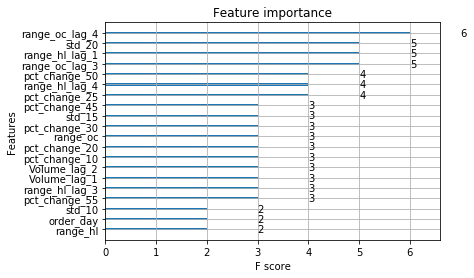

In [54]:
# Plot the top 7 features
xgboost.plot_importance(model, max_num_features = 20)
# Show the plot
plt.show()

### Predict and Classification report

In [21]:
# Predict the trading signal on test dataset
y_pred = model.predict(X_test)
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.46      0.48       524
           1       0.52      0.56      0.54       552

   micro avg       0.51      0.51      0.51      1076
   macro avg       0.51      0.51      0.51      1076
weighted avg       0.51      0.51      0.51      1076



### Confusion Matrix

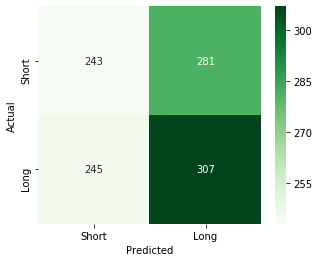

In [22]:
array = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
'Short', 'Long'])
plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Individual stock performance

Let’s see how the XGBoost based strategy returns held up against the normal daily returns ie the buy and hold strategy. We will plot a comparison graph between the strategy returns and the daily returns for all the companies we had mentioned before. The code is as follows:

CBOM.ME


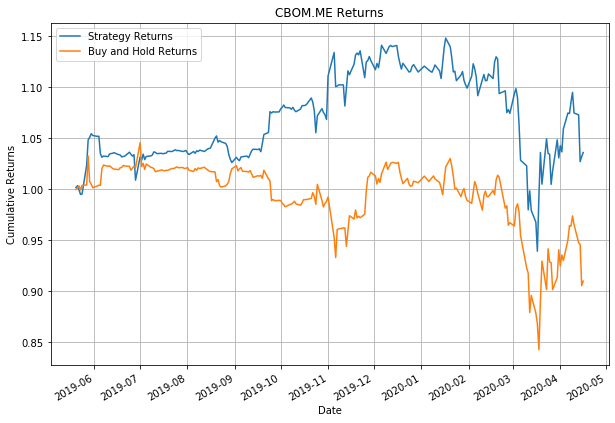

ALRS.ME


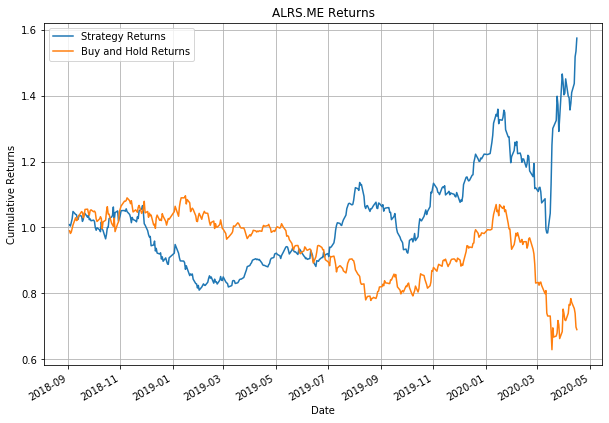

YNDX


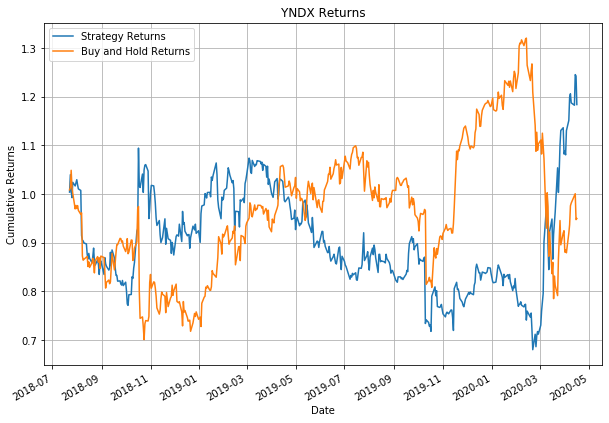

In [23]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)
# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
    # Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]
    # Define the train and test dataset
    train_length = int(len(X)*0.80)
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal
    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    # Plot the stock strategy and buy and hold returns
    print(stock_name)
    # Set the figure size
    plt.figure(figsize=(10, 7))
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
    plt.grid()
    plt.show()

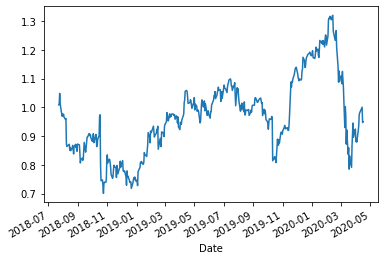

In [24]:
(stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()

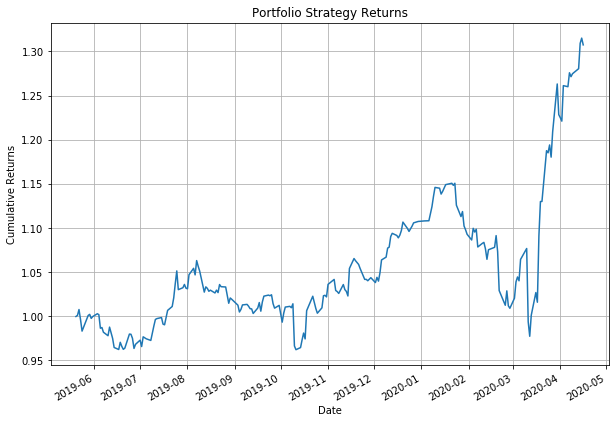

In [25]:
# Drop missing values
portfolio.dropna(inplace=True)
# Set the figure size
plt.figure(figsize=(10, 7))
# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()
# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [26]:
portfolio

,CBOM.ME,ALRS.ME,YNDX
Date,,,
2019-05-20,0.001681,0.012448,-0.014917
2019-05-21,0.001846,0.008031,-0.006147
2019-05-22,-0.004019,-0.009558,0.033466
2019-05-23,-0.004540,-0.003898,-0.025282
2019-05-24,0.000335,0.000666,-0.040472
2019-05-28,0.024410,0.014770,0.014805
2019-05-29,0.002502,0.002953,-0.001651
2019-05-30,0.003345,-0.004101,-0.012916
2019-05-31,-0.001678,-0.005332,0.013363


Start date,2019-05-20
End date,2020-04-16
Total months,10
,Backtest
Annual return,35.4%
Cumulative returns,30.7%
Annual volatility,21.5%
Sharpe ratio,1.52
Calmar ratio,2.35
Stability,0.55
Max drawdown,-15.1%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.06,2020-01-23,2020-03-12,2020-03-23,43
1,9.49,2019-08-07,2019-10-11,2019-11-18,74
2,4.49,2019-05-22,2019-06-17,2019-07-22,44
3,3.33,2020-03-30,2020-04-02,2020-04-07,7
4,2.56,2019-11-18,2019-12-02,2019-12-09,16


Stress Events,mean,min,max
New Normal,0.13%,-7.71%,7.39%


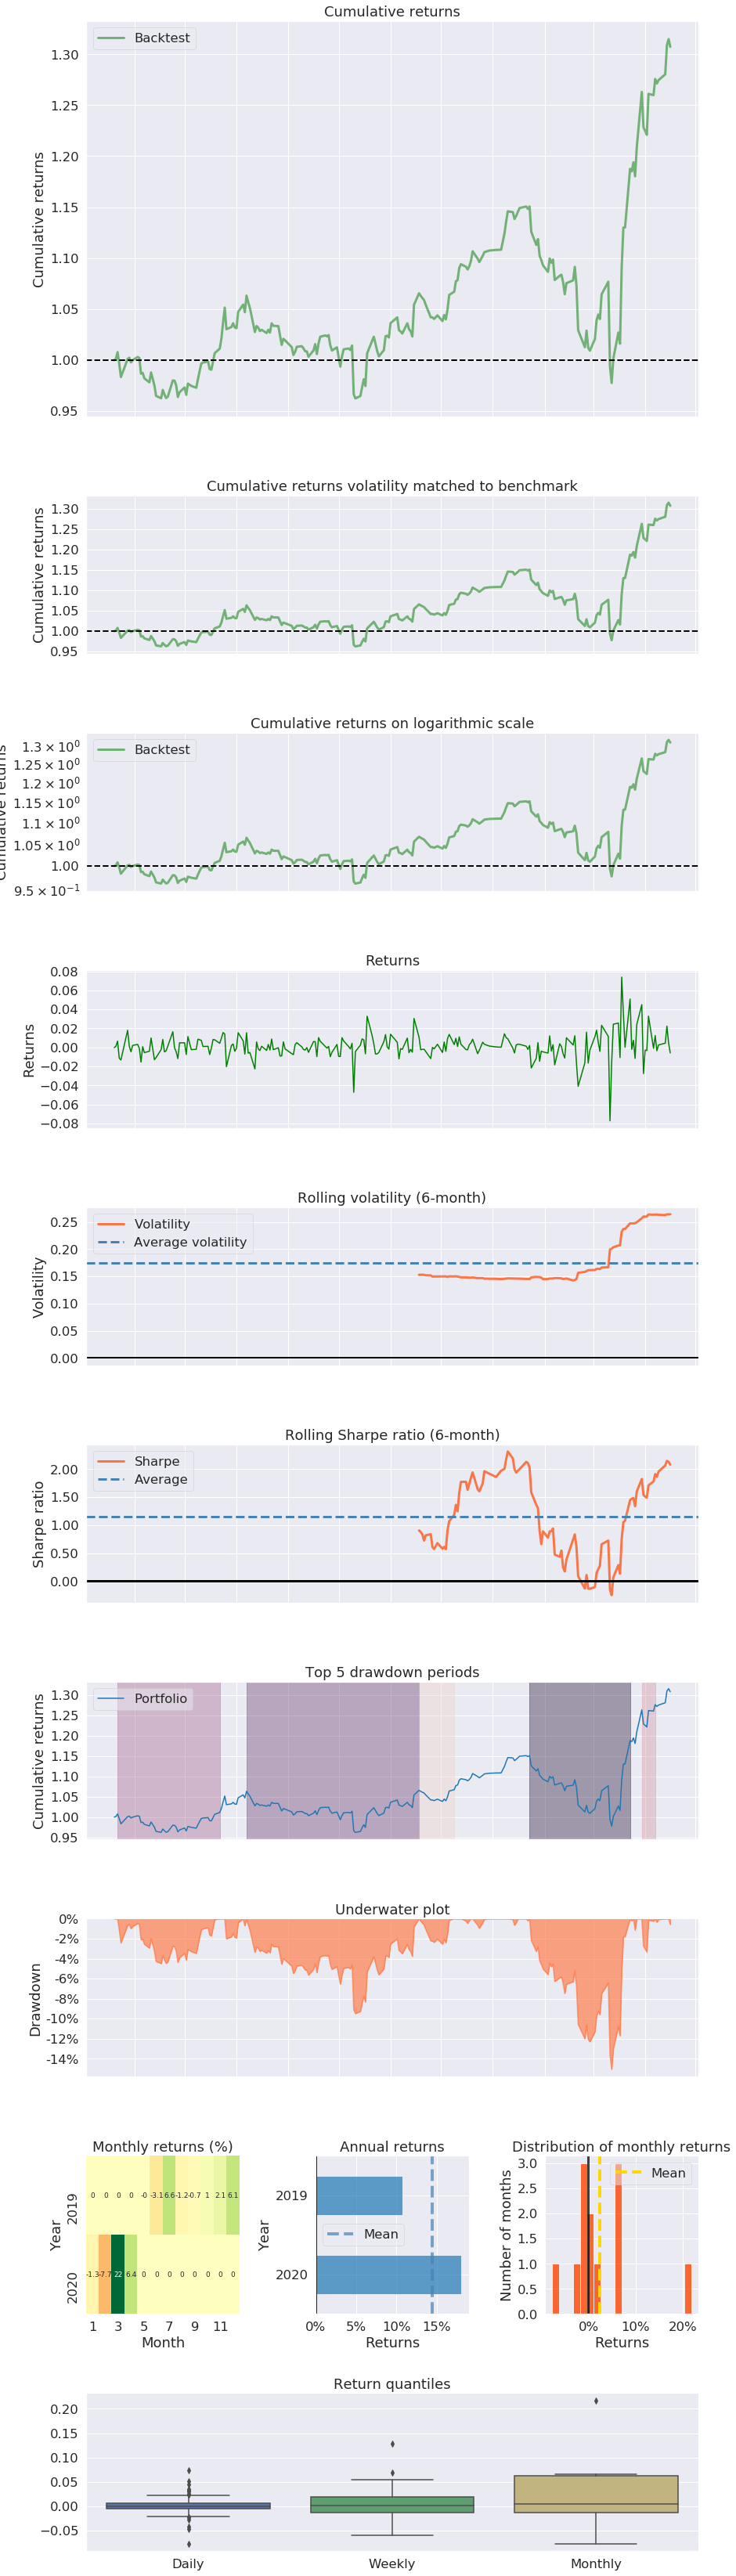

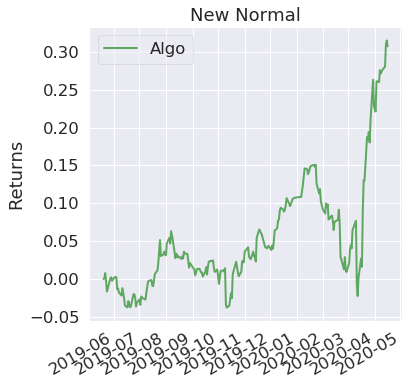

In [27]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis = 1))

# Lets make the strategy better using GridSearchCV

In [59]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [88]:
xgb_model = XGBClassifier(random_state=13)
params = {'max_depth': [9], 
          'subsample': [0.9],
          'colsample_bytree': [1],
          'n_estimators': [200]} 
cv = StratifiedKFold(shuffle=True, n_splits=5)

In [89]:
GS_xgb_model = GridSearchCV(estimator=xgb_model, param_grid=params, cv=cv, scoring='roc_auc', n_jobs=-1)

In [90]:
%%time
GS_xgb_model.fit(X=X_train, y=y_train)

Wall time: 1min 6s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w...pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [8, 9], 'subsample': [0.9], 'colsample_bytree': [1], 'n_estimators': [150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [91]:
GS_xgb_model.best_score_

0.5078296695467194

In [92]:
GS_xgb_model.best_params_

{'colsample_bytree': 1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.9}

In [86]:
xgb_best = GS_xgb_model.best_estimator_

In [87]:
xgb_best

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=150, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=13, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
       validate_parameters=False, verbosity=None)

In [74]:
0.5210230737915391 - 0.5072755006799302

0.013747573111608902

In [ ]:
0.5210230737915391